<a href="https://colab.research.google.com/github/pragyamishra12/K-Means-Implementation/blob/main/KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import math
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


import random
random.seed(10)

In [ ]:
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Iris.csv to Iris.csv


In [ ]:
def get_iris_data(Iris):


    # Specify column names and read in data
    i_names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
    iris = pd.read_table(os.path.join(os.getcwd(), Iris), header=None, sep=',', names=i_names)

    return iris

In [ ]:
df = (pd.read_csv('Iris.csv'))

df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [ ]:
df['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

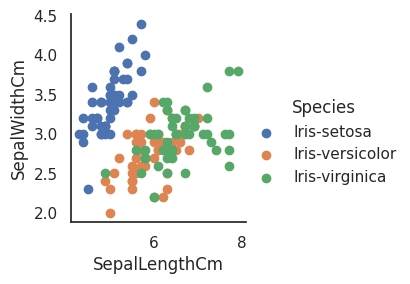

In [ ]:
sns.FacetGrid(df, hue="Species") \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend()

<Axes: xlabel='Species', ylabel='PetalWidthCm'>

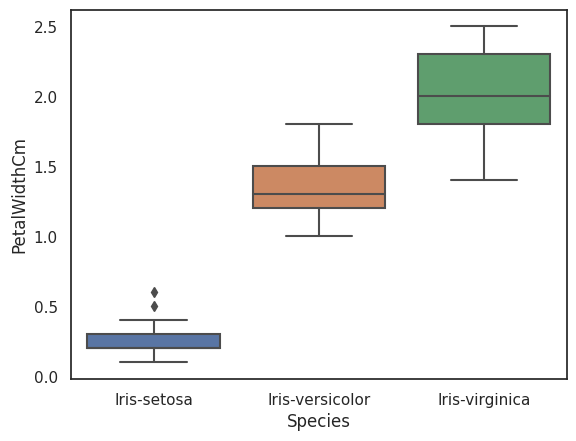

In [ ]:
sns.boxplot(x="Species", y="PetalWidthCm", data=df)

In [ ]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.data = pd.DataFrame()
        self.n_clusters = n_clusters
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)
        self.old_centroids = pd.DataFrame()
        self.verbose = False
        self.predictions = list()

    def train(self, df, verbose):
        self.verbose = verbose
        self.data = df.copy(deep=True)
        self.clusters = np.zeros(len(self.data))

        if 'Species' in self.data.columns:
            self.data.drop('Species', axis=1, inplace=True)

        # Randomly initialize centroids
        unique_rows = self.data.drop_duplicates()
        unique_rows.reset_index(drop=True, inplace=True)
        self.centroids = unique_rows.sample(n=self.n_clusters)
        self.centroids.reset_index(drop=True, inplace=True)

        if self.verbose:
            print("\nRandomly initiated centroids:")
            print(self.centroids)

        # Initialize old centroids as a matrix of all 0's
        self.old_centroids = pd.DataFrame(np.zeros(shape=(self.n_clusters, self.data.shape[1])),
                                          columns=self.data.columns)

        # Compare every data point in our dataset to each of the k-means and assign each point to closest cluster
        while not self.old_centroids.equals(self.centroids):

            if self.verbose:
                time.sleep(3)

            # Stash old centroids
            self.old_centroids = self.centroids.copy(deep=True)

            # Iterate through each data point in the matrix
            for row_i in range(0, len(self.data)):
                distances = list()
                point = self.data.iloc[row_i]

                # Calculate the distance between the current point and each of the centroids
                for row_c in range(0, len(self.centroids)):
                    centroid = self.centroids.iloc[row_c]
                    distances.append(np.linalg.norm(point - centroid))

                # Assign this data point to a cluster
                self.clusters[row_i] = np.argmin(distances)

            # For each cluster extract the values which now belong to each cluster and calculate new k-means
            for cls in range(0, self.n_clusters):

                cls_idx = np.where(self.clusters == cls)[0]

                if len(cls_idx) == 0:
                    self.centroids.loc[cls] = self.old_centroids.loc[cls]
                else:
                    # Set the new k-mean to the mean value of the data points within this cluster
                    self.centroids.loc[cls] = self.data.iloc[cls_idx].mean()

                if self.verbose:
                    print("\nRow indices belonging to cluster {}: [n={}]".format(cls, len(cls_idx)))
                    print(cls_idx)

            if self.verbose:
                print("\nOld centroids:")
                print(self.old_centroids)
                print("New centroids:")
                print(self.centroids)

In [ ]:
# Run through a simple application
number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.train(df=df, verbose=False)

In [ ]:
# Extract the results
df['cluster'] = kmeans.clusters
centroids = kmeans.centroids
centroids['cluster'] = 'centroid'
all_df = pd.concat([df, centroids])

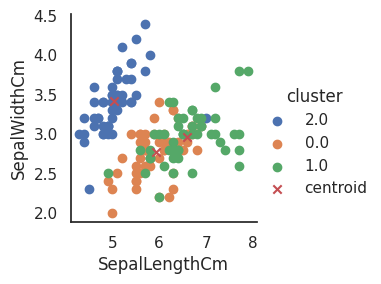

In [ ]:
# Plot the cluster centroids
sns.FacetGrid(all_df, hue="cluster", hue_kws={"marker":["o", "o", "o", "x"]}).map(plt.scatter, "SepalLengthCm", "SepalWidthCm").add_legend()

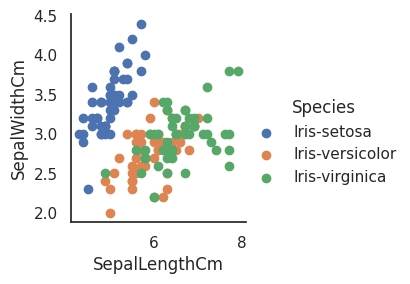

In [ ]:
# Plot the clusters
sns.FacetGrid(all_df, hue="Species").map(plt.scatter, "SepalLengthCm", "SepalWidthCm").add_legend()

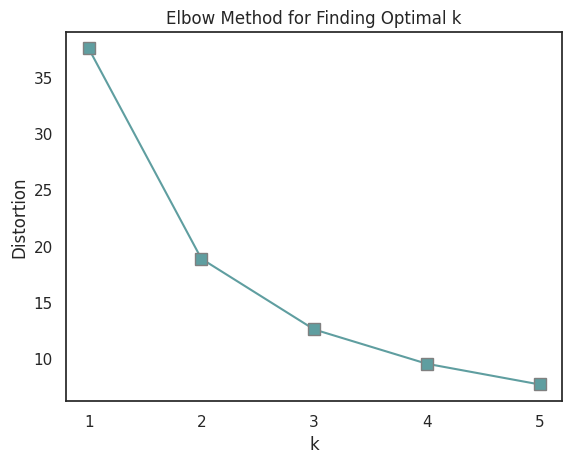

In [ ]:
# Set up parameters
sil_coefs = list()
distortions = list()
K = [1, 2, 3, 4, 5]

# Test out multiple values for k
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.train(df=df, verbose=False)

    # Extract the results
    df['cluster'] = kmeans.clusters

    # Calculate distortion
    centroid_vals = kmeans.centroids[kmeans.centroids.columns[:-1]]
    d = df[df.columns[:-2]]
    distortion = sum(np.min(cdist(d, centroid_vals, 'euclidean'), axis=1)) / d.shape[0]



    # Keep track of cluster size metrics
    distortions.append(distortion)


# Elbow plot
plt.plot(K, distortions, 's-', markersize=8, color='cadetblue', mec='gray')
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()